At the end of the experiment:

1. Understand the role of the momentum parameter
2. Observe what happens when momentum value is set to high or low
3. Different weight initialization techniques like Xavier, he



The dataset used for this experiment is CIFAR-100. It  has 100 classes which contains 600 images for each class. There are 500 training images and 100 testing images per class. These 100 classes are grouped into 20 superclasses. Each image comes with the class and superclass it belongs to.

Here is the list of classes in the CIFAR-100:

| Superclass 	 | Classes|
|--------------------|-------------|
|aquatic mammals | 	beaver, dolphin, otter, seal, whale |
|fish |	aquarium fish, flatfish, ray, shark, trout |
|flowers| 	orchids, poppies, roses, sunflowers, tulips |
|food containers| 	bottles, bowls, cans, cups, plates|
|fruit and vegetables| 	apples, mushrooms, oranges, pears, sweet peppers|
|household electrical devices | clock, computer keyboard, lamp, telephone, television|
|household furniture| 	bed, chair, couch, table, wardrobe|
|insects | 	bee, beetle, butterfly, caterpillar, cockroach |
|large carnivores| 	bear, leopard, lion, tiger, wolf|
|large man-made outdoor things |	bridge, castle, house, road, skyscraper|
|large natural outdoor scenes |	cloud, forest, mountain, plain, sea|
|large omnivores and herbivores |	camel, cattle, chimpanzee, elephant, kangaroo|
|medium-sized mammals |	fox, porcupine, possum, raccoon, skunk|
|non-insect invertebrates|	crab, lobster, snail, spider, worm|
|people| 	baby, boy, girl, man, woman|
|reptiles |	crocodile, dinosaur, lizard, snake, turtle|
|small mammals| 	hamster, mouse, rabbit, shrew, squirrel |
|trees|	maple, oak, palm, pine, willow |
|vehicles 1 |	bicycle, bus, motorcycle, pickup truck, train |
|vehicles 2 |	lawn-mower, rocket, streetcar, tank, tractor |



The dataset is downloaded from following url :

https://www.cs.toronto.edu/~kriz/cifar.html

**Importing required packages**

In [ ]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
# Checking for GPU instance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Intilizaing the accuracy value as zero
best_acc = 0

#### Preparing the dataset

In [ ]:
print('\n[Phase 1] : Data Preparation')

##dataset
dataset = 'cifar100'

# Preparing the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
]) # meanstd transformation


[Phase 1] : Data Preparation


#### Applying the standard mean

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
])

In [ ]:
# number of classes in the dataset
num_classes = 100

In [ ]:
### Downloading the dataset
trainset = torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='data', train=False, download=False, transform=transform_test)
### Loading the dataset 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)


Extracting data/cifar-100-python.tar.gz to data


#### Let us define the network

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes, init_mode='xavier'):  ### supports 'zero', 'normal', 'xavier', 'he' inits
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
        if init_mode == 'zero':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.zero_()   ### fill tensor elements with zeros
                    if m.bias is not None:
                        m.bias.data.zero_()
        
        if init_mode == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.normal_()   ### fill tensor elements with random numbers from normal distribution
                    if m.bias is not None:
                        m.bias.data.normal_()
        
        if init_mode == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                    n = fan_in + fan_out
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in+fan_out))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
        
        if init_mode == 'he':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
                
                
    ## Forward Pass
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return(out)

In [ ]:
## Calling the model with Xavier
net = LeNet(num_classes, init_mode='xavier')# You rerun this entire experiment alternate values to 'xavier' (check ungraded exercise below)
## Checking for GPU instance 
net = net.to(device)

In [ ]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    # Declaring the Variables
    train_loss = 0
    correct = 0
    total = 0
    # Loopiing over train data
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Checking for GPU instance
        #if use_cuda:
        inputs, targets = inputs.to(device), targets.to(device)
        # Optimizer
        optimizer.zero_grad()
        # Converting inputs and targets into pytorch variables
        #inputs, targets = Variable(inputs), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        # Storing the outputs size
        size_ = outputs.size()
        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Backward Pass
        loss.backward()
        # Optimizer steps
        optimizer.step()
        ## Calculating the traqin loss
        train_loss += loss.item()
        # Predicting the values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the targets size
        total += targets.size(0)
        # Calculating the corrected values
        correct += predicted.eq(targets.data).cpu().sum().item()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Storing number of epoch, loss and accuracy in a file
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [ ]:
def test(epoch):
    global best_acc
    net.eval()
    # Declaring the variables
    test_loss = 0
    correct = 0
    total = 0
    # Looping over the test data
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # Checking for GPU instance
        #if use_cuda:
        inputs, targets = inputs.to(device), targets.to(device)
        ## Coverting inputs and targets intp pytorch variables
        #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        # Forward pass
        outputs = net(inputs)
        # Storing the size of outputs
        size_ = outputs.size()
        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Calculating the test loss
        test_loss += loss.item()
        # Predicted values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the size of targets
        total += targets.size(0)
        # Calculating the correct values
        correct += predicted.eq(targets.data).cpu().sum().item()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            # printing the progress bar
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Printing the validation loss 
    print('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    # Storing number of epoch,loss and acuracy in a file
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    # Checking for best accuracy
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net,
            'acc': acc,
            'epoch': epoch,
        }
        # Checking for the directory
        if not os.path.isdir('../checkpoint'):
            # creating the directory
            os.mkdir('../checkpoint')
        # saving the data
        torch.save(state, '../checkpoint_ckpt.t7')
        # Storing the accuracy value
        best_acc = acc

### Training without momentum

In [ ]:
experiment = 'no_momentum'
# Creating files in write mode
train_loss_file = open(experiment+"train_loss.txt", "w")
val_loss_file = open(experiment+"val_loss.txt", "w")

In [ ]:
# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
# Training and Testing the model for 30 epochs
for epoch in range(0, 30):
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
# Closing the values   
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.606 | Acc: 1.496% (748/50000)   391/391 
 [==================================>] | Loss: 4.580 | Acc: 1.780% (178/10000)   100/100 
val_loss:  4.580091757774353 accuracy:  1.78
Saving..

Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 [==================================>] | Loss: 4.542 | Acc: 2.132% (1066/50000)  391/391 
 [==================================>] | Loss: 4.485 | Acc: 2.840% (284/10000)   100/100 
val_loss:  4.485440502166748 accuracy:  2.84
Saving..

Epoch: 2
 [==================================>] | Loss: 4.444 | Acc: 3.234% (1617/50000)  391/391 
 [==================================>] | Loss: 4.378 | Acc: 3.890% (389/10000)   100/100 
val_loss:  4.378374085426331 accuracy:  3.89
Saving..

Epoch: 3
 [==================================>] | Loss: 4.313 | Acc: 4.896% (2448/50000)  391/391 
 [==================================>] | Loss: 4.213 | Acc: 6.300% (630/10000)  

#### Plotting the Training curves

30 30


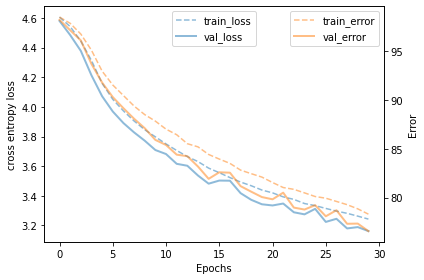

In [ ]:
training_curves(experiment)

In [ ]:
best_acc = 0
# Calling the model
net = LeNet(num_classes, init_mode='xavier')
# Checking for GPU instance
net = net.to(device)

In [ ]:
experiment = 'with_momentum'
# Cretaing files in write mode
train_loss_file = open(experiment+"train_loss.txt", "w")
val_loss_file = open(experiment+"val_loss.txt", "w")

In [ ]:
# Optimizer 
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# Training and Testing the model for 30 epochs
for epoch in range(0, 10):
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
# Closing the files
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.311 | Acc: 4.758% (2379/50000)  391/391 
 [==================================>] | Loss: 3.970 | Acc: 8.660% (866/10000)   100/100 
val_loss:  3.9699780249595644 accuracy:  8.66
Saving..

Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 [==================================>] | Loss: 3.865 | Acc: 10.964% (5482/50000) 391/391 
 [==================================>] | Loss: 3.698 | Acc: 13.960% (1396/10000) 100/100 
val_loss:  3.6983616185188293 accuracy:  13.96
Saving..

Epoch: 2
 [==================================>] | Loss: 3.670 | Acc: 13.842% (6921/50000) 391/391 
 [==================================>] | Loss: 3.548 | Acc: 15.670% (1567/10000) 100/100 
val_loss:  3.5484558391571044 accuracy:  15.67
Saving..

Epoch: 3
 [==================================>] | Loss: 3.541 | Acc: 15.800% (7900/50000) 391/391 
 [==================================>] | Loss: 3.461 | Acc: 17.520% (1752/10000)

#### Plotting the training curves

10 10


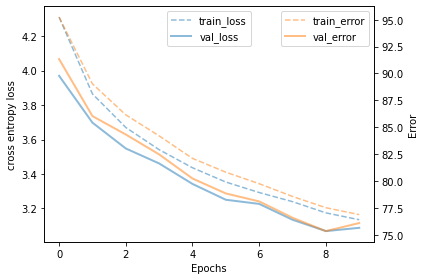

In [ ]:
training_curves(experiment)